<a href="https://colab.research.google.com/github/itsSuryanshu/3-pre-trained-CNNmodels-LungDisease/blob/main/CNNmodelScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""Resets Current Session and Removes Directories"""
!rm -rf /content/*

In [ ]:
"""Saves Output to Google Drive"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gradio
!pip install kaggle

In [ ]:
"""
IMPORTS
"""
import os
import numpy as np
import keras
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.data import AUTOTUNE

In [ ]:
"""This unzips the dataset and loads it"""
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fatemehmehrparvar/lung-disease
!unzip lung-disease.zip

"""Dataset and file structure manipulation"""

root = 'Lung X-Ray Image'
data_folder = os.path.join(root, 'Lung X-Ray Image')

targets = ['Normal', 'Viral Pneumonia']

for target in targets:
  os.makedirs(os.path.join(root, target), exist_ok = True)

for target_dir in targets:
    src_dir = os.path.join(data_folder, target_dir)
    dest_dir = os.path.join(root, target_dir)

    if os.path.exists(src_dir):
        for file_name in os.listdir(src_dir):
            src_file = os.path.join(src_dir, file_name)
            dest_file = os.path.join(dest_dir, file_name)
            shutil.move(src_file, dest_file)

lung_opacity_dir = os.path.join(data_folder, 'Lung Opacity')
if os.path.exists(lung_opacity_dir):
    shutil.rmtree(lung_opacity_dir)

if not os.listdir(data_folder):
    os.rmdir(data_folder)

shutil.rmtree(data_folder)

In [ ]:
"""Removes corrupted images"""

num_skipped = 0
for folder_name in ("Normal", "Viral Pneumonia"):
    folder_path = os.path.join("Lung X-Ray Image", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

In [ ]:
image_size = (180, 180)
batch_size = 32

class_names = ['Normal', 'Viral Pneumonia']

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "Lung X-Ray Image",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=class_names,
    label_mode='int'
)

Found 2350 files belonging to 2 classes.
Using 1880 files for training.
Using 470 files for validation.


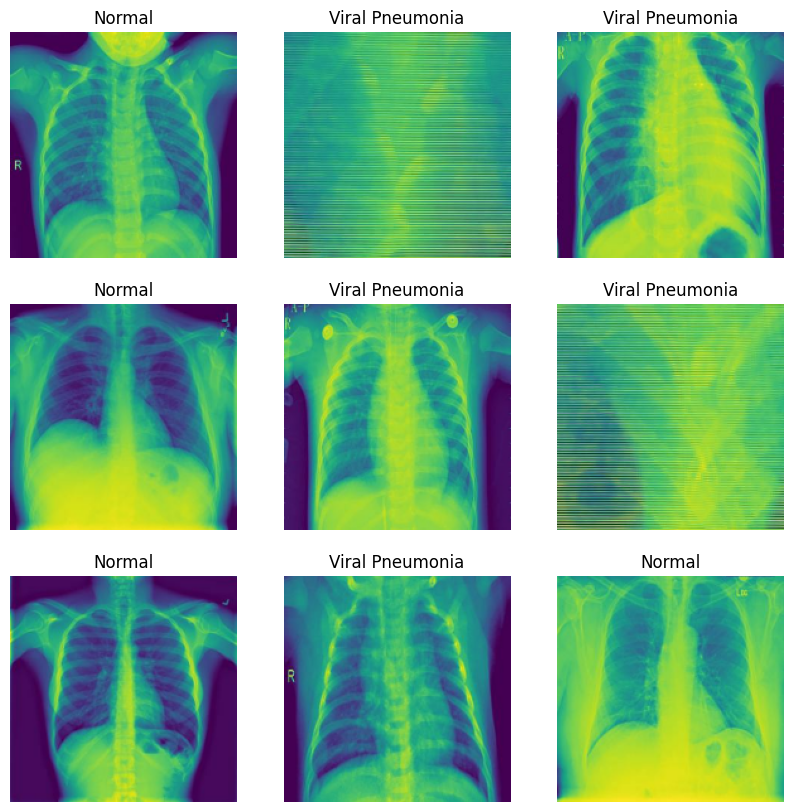

In [ ]:
"""First 9 images in dataset"""

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

# Apply data augmentation to the training dataset
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

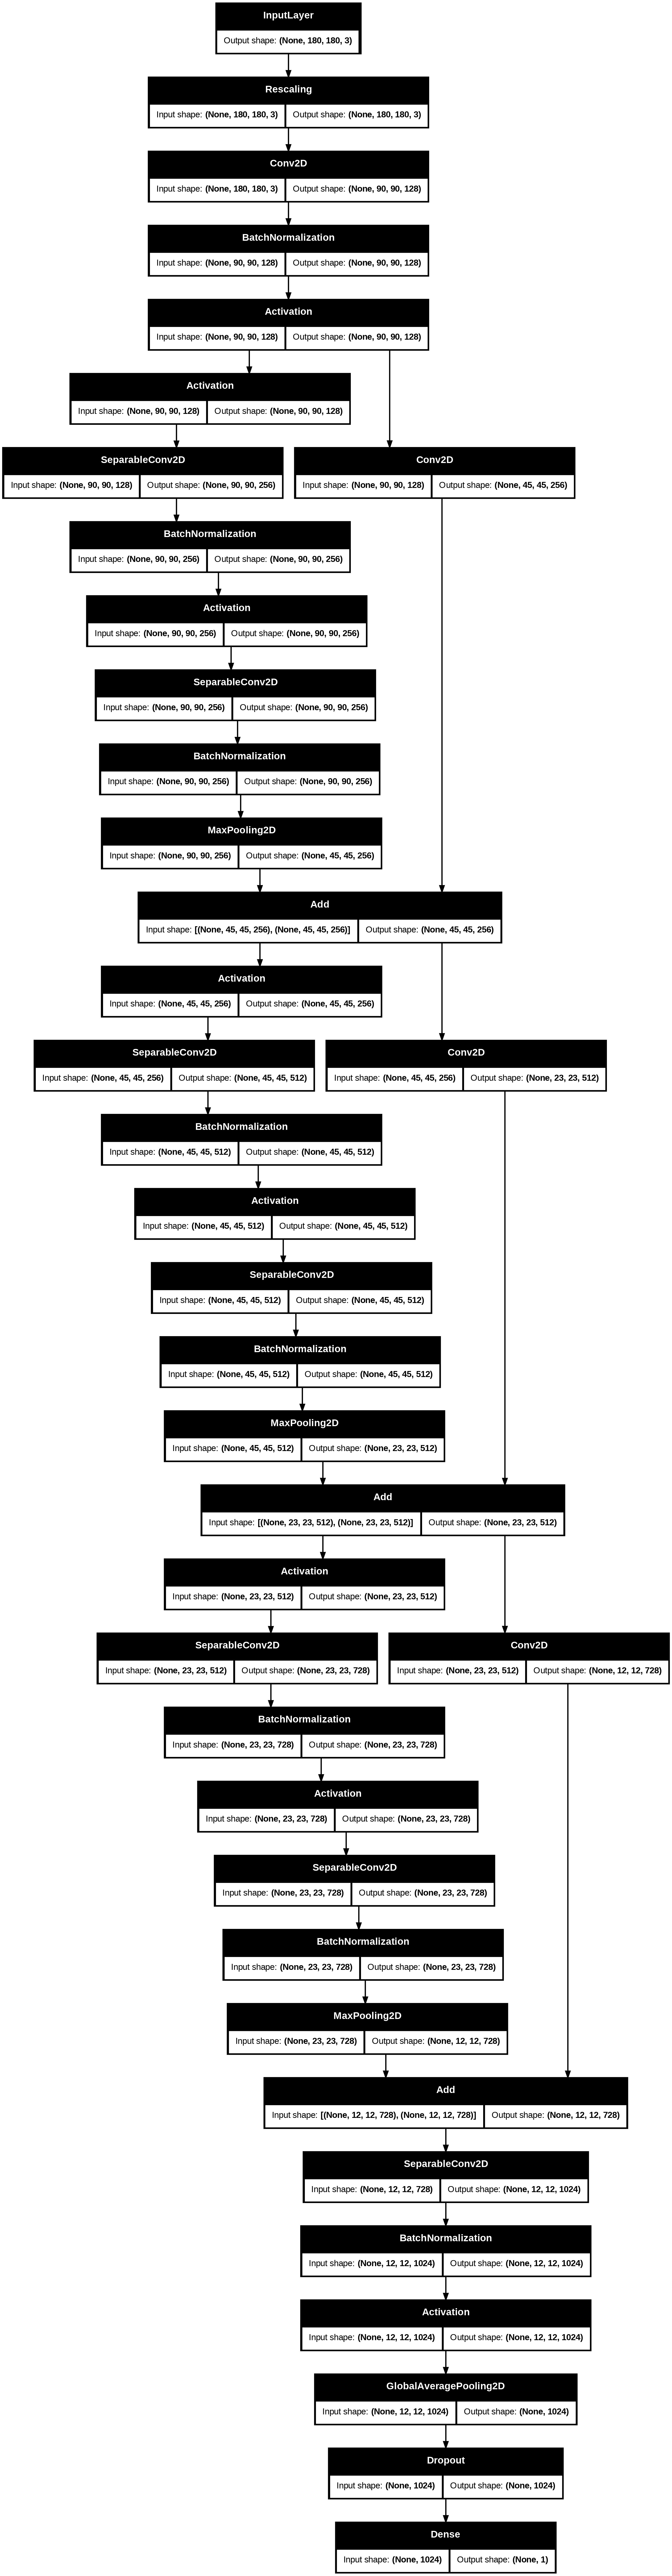

In [ ]:
"""Building Model"""
import tensorflow as tf

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
"""Training"""
total_epochs = 15

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=total_epochs,
    validation_data=val_ds,
)

Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 318s 5s/step - acc: 0.8027 - loss: 0.4071 - val_acc: 0.5213 - val_loss: 0.6968
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - acc: 0.9389 - loss: 0.1830 - val_acc: 0.5213 - val_loss: 0.7208
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 305s 5s/step - acc: 0.9330 - loss: 0.1503 - val_acc: 0.4787 - val_loss: 0.8034
Epoch 4/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - acc: 0.9456 - loss: 0.1272 - val_acc: 0.4787 - val_loss: 0.9314
Epoch 5/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 298s 5s/step - acc: 0.9475 - loss: 0.1305 - val_acc: 0.4787 - val_loss: 1.1844
Epoch 6/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 296s 5s/step - acc: 0.9611 - loss: 0.1056 - val_acc: 0.4787 - val_loss: 1.5040
Epoch 7/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 296s 5s/step - acc: 0.9661 - loss: 0.0968 - val_acc: 0.4787 - val_loss: 2.1468
Epoch 8/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 299s 5s/step - acc: 0.9634 - loss: 0.0897 - val_acc: 0.4787 - val_loss: 2.8556
Epoch 9/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 281s 5s/step - acc: 0.9733

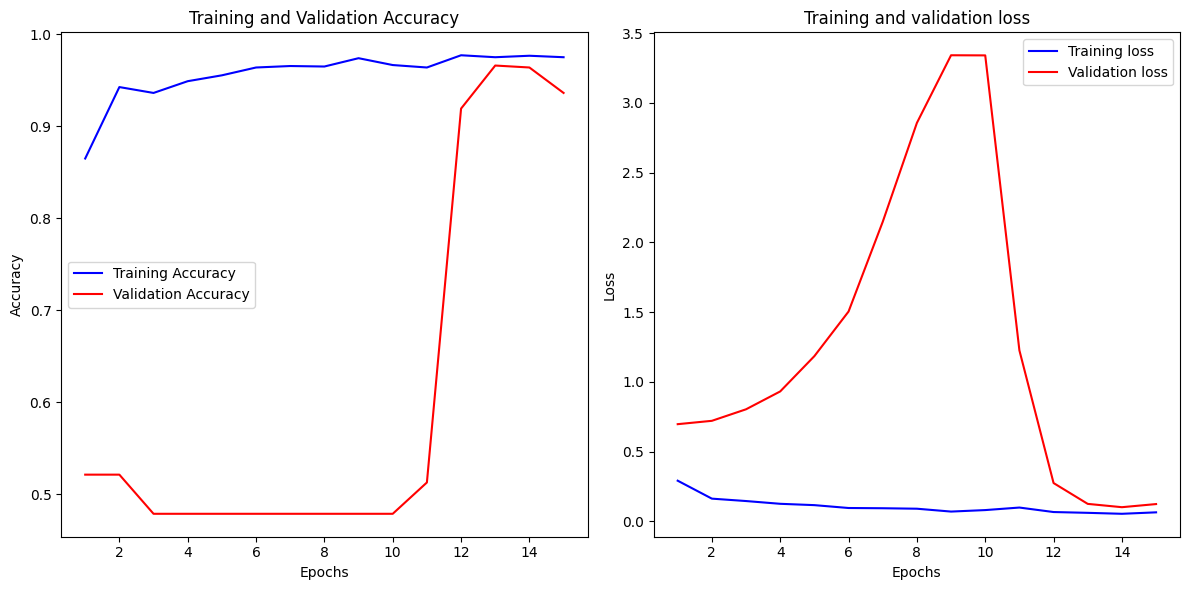

In [ ]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('drive/MyDrive/outputs/Training_and_Validation_Data.jpg')
plt.show()

In [ ]:
model.save("drive/MyDrive/outputs/KerasModel.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
This image is 0.05 % Normal and 99.95% Viral Pneumonia


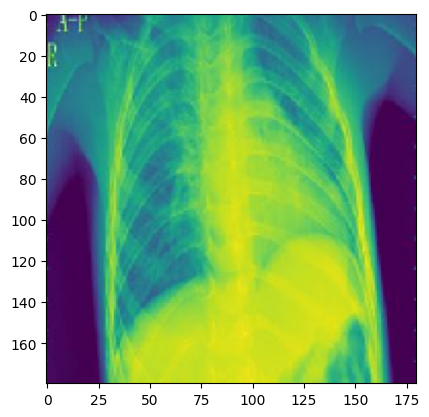

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

img = keras.utils.load_img("Lung X-Ray Image/Viral Pneumonia/1019.jpg", target_size=(180, 180))
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = model.predict(img_array)
result = np.array(prediction[0])
score = float(tf.sigmoid(prediction[0][0]))
print(f'This image is {100 * (1 - score):.2f} % Normal and {100 * score:.2f}% Viral Pneumonia')